In [51]:
#http://cse.unl.edu/~byrav/INFOCOM2011/workshops/papers/p713-achrekar.pdf
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import lag_plot

Autoregression model: Input variables are taken as observations at previous time steps (AKA lag variables). Uses data from same input variable at previous time steps.

# Cleaning Data

## CDC Data

In [35]:
def clean_df(df):
    df.reset_index(inplace=True) # Resets the index, makes factor a column
    df.drop('PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS',axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df["Date"] = pd.to_datetime(df.WEEK.astype(str)+
                              df.YEAR.astype(str).add('-1') ,format='%W%Y-%w')
    df.set_index(df['Date'], inplace=True)
    df['ILITOTAL'] = df['ILITOTAL'].astype('int64')
    return df

In [36]:
cdc_16 = pd.read_csv('FluViewPhase2Data/16_17.csv')
cdc_17 = pd.read_csv('FluViewPhase2Data/17_18.csv')

cdc_16 = clean_df(cdc_16)
cdc_16 = cdc_16.drop(['AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'Date', 'YEAR','WEEK',  
              '%UNWEIGHTED ILI', 'TOTAL PATIENTS'], axis=1)
cdc_17 = clean_df(cdc_17)
cdc_17 = cdc_17.drop(['REGION TYPE', 'REGION', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'Date', 'YEAR','WEEK', '% WEIGHTED ILI', 
              '%UNWEIGHTED ILI'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
cdc_df = pd.concat([cdc_16, cdc_17])

## Twitter Data

## Google Trends Data

In [49]:
google_df = pd.read_csv('google_trends/multiTimeline.csv')
google_df.reset_index(inplace=True) # Resets the index, makes factor a column
google_df.columns = google_df.iloc[0]
google_df = google_df.iloc[1:]
google_df.rename(columns={'Week': 'Date'}, inplace=True)
google_df.rename(columns={'flu: (United States)': 'Count'}, inplace=True)
google_df.set_index(google_df['Date'], inplace=True)
google_df.drop(['Date'], axis=1, inplace=True)
google_df['Count'] = google_df['Count'].astype('int64')

# Data Visualizations

## CDC Data

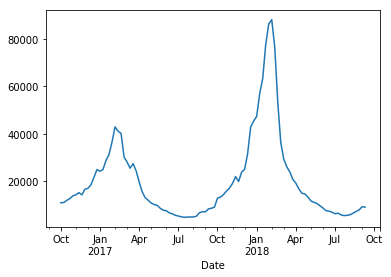

In [33]:
cdc_df.plot()
plt.legend().set_visible(False)
plt.show()

## Twitter Data

## Google Trends Data

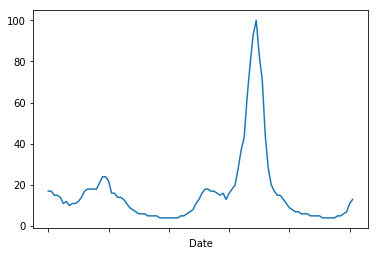

In [45]:
google_df.plot()
plt.legend().set_visible(False)
plt.show()

# Check for Autocorrelation

## CDC data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


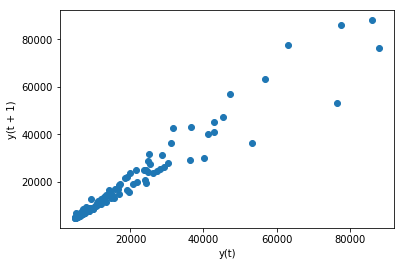

In [52]:
#plot the observation at the previous time step 
#(t-1) with the observation at the next time step (t+1) as a scatter plot.
#plots the visits(t) on the x-axis against 
#the visits on the previous day (t-1) on the y-axis.
lag_plot(cdc_df)
#clear correlation